In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.pyplot import imshow
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import KFold
import seaborn as sns

In [2]:
#root = '101_ObjectCategories'
#exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
root = 'C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/Data'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
#categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/Data\\FTD', 'C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/Data\\Normal']


This function is useful for pre-processing the data into an image and input vector.

In [3]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [4]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [5]:
# random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [6]:
num_folds = 10
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 42)
fold_no = 1
for train, test in kfold.split(data):
  #print("TRAIN:", train, "TEST:", test)
  if os.path.exists(f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/train{fold_no}.csv") == False:
    np.savetxt(f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/train{fold_no}.csv", train, delimiter=",", fmt='%s')
    np.savetxt(f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/test{fold_no}.csv", test, delimiter=",", fmt='%s')
  else:
    print("exists")
  fold_no = fold_no + 1

exists
exists
exists
exists
exists
exists
exists
exists
exists
exists


In [7]:
X, y = np.array([t["x"] for t in data]), np.array([t["y"] for t in data])

# normalize data
X = X.astype('float32') / 255.



### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

(1355, 2)
finished loading 13544 images from 2 categories
train / test split: 12189, 1355
training data shape:  (12189, 224, 224, 3)
training labels shape:  (12189, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                    

Epoch 14/150
379/381 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9297
Epoch 00014: val_accuracy did not improve from 0.91882
381/381 [==============================] - 5s 14ms/step - loss: 0.1805 - accuracy: 0.9296 - val_loss: 0.2212 - val_accuracy: 0.9181
Epoch 15/150
378/381 [============================>.] - ETA: 0s - loss: 0.1824 - accuracy: 0.9283
Epoch 00015: val_accuracy did not improve from 0.91882
381/381 [==============================] - 5s 14ms/step - loss: 0.1817 - accuracy: 0.9287 - val_loss: 0.2184 - val_accuracy: 0.9114
Epoch 16/150
379/381 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9341
Epoch 00016: val_accuracy did not improve from 0.91882
381/381 [==============================] - 5s 13ms/step - loss: 0.1659 - accuracy: 0.9340 - val_loss: 0.2076 - val_accuracy: 0.9173
Epoch 17/150
377/381 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9379
Epoch 00017: val_accuracy improved from 0.91882

380/381 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9711
Epoch 00042: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 13ms/step - loss: 0.0781 - accuracy: 0.9712 - val_loss: 0.2396 - val_accuracy: 0.9159
Epoch 43/150
377/381 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9766
Epoch 00043: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0729 - accuracy: 0.9768 - val_loss: 0.2897 - val_accuracy: 0.9092
Epoch 44/150
378/381 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9718
Epoch 00044: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0782 - accuracy: 0.9717 - val_loss: 0.2758 - val_accuracy: 0.9218
Epoch 45/150
377/381 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9710
Epoch 00045: val_accuracy did not improve from 0.92841
381/3

Epoch 71/150
377/381 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 0.9790
Epoch 00071: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0638 - accuracy: 0.9790 - val_loss: 0.2787 - val_accuracy: 0.9188
Epoch 72/150
381/381 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9834
Epoch 00072: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0525 - accuracy: 0.9834 - val_loss: 0.2804 - val_accuracy: 0.9188
Epoch 73/150
380/381 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9799
Epoch 00073: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0609 - accuracy: 0.9799 - val_loss: 0.2952 - val_accuracy: 0.9166
Epoch 74/150
379/381 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9796
Epoch 00074: val_accuracy did not improve from 

Epoch 100/150
378/381 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9826
Epoch 00100: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0540 - accuracy: 0.9827 - val_loss: 0.3124 - val_accuracy: 0.9159
Epoch 101/150
381/381 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9835
Epoch 00101: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0465 - accuracy: 0.9835 - val_loss: 0.3429 - val_accuracy: 0.9232
Epoch 102/150
380/381 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9879
Epoch 00102: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0355 - accuracy: 0.9879 - val_loss: 0.2899 - val_accuracy: 0.9240
Epoch 103/150
380/381 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9855
Epoch 00103: val_accuracy improved from 0.9

379/381 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9868
Epoch 00128: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 13ms/step - loss: 0.0394 - accuracy: 0.9869 - val_loss: 0.3074 - val_accuracy: 0.9137
Epoch 129/150
379/381 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9862
Epoch 00129: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 13ms/step - loss: 0.0479 - accuracy: 0.9861 - val_loss: 0.3188 - val_accuracy: 0.9269
Epoch 130/150
379/381 [============================>.] - ETA: 0s - loss: 0.0409 - accuracy: 0.9864
Epoch 00130: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 13ms/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.3194 - val_accuracy: 0.9232
Epoch 131/150
381/381 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9878
Epoch 00131: val_accuracy did not improve from 0.92989
38

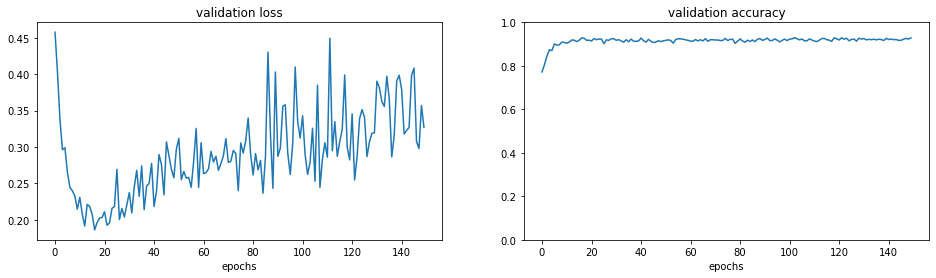

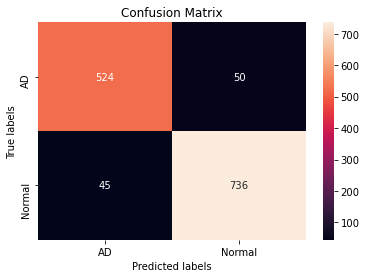

(1355, 2)
finished loading 13544 images from 2 categories
train / test split: 12189, 1355
training data shape:  (12189, 224, 224, 3)
training labels shape:  (12189, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 109, 109, 32)      0         
                  

Epoch 13/150
380/381 [============================>.] - ETA: 0s - loss: 0.1874 - accuracy: 0.9240
Epoch 00013: val_accuracy did not improve from 0.91144
381/381 [==============================] - 5s 14ms/step - loss: 0.1873 - accuracy: 0.9240 - val_loss: 0.2128 - val_accuracy: 0.9063
Epoch 14/150
377/381 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9265
Epoch 00014: val_accuracy improved from 0.91144 to 0.91218, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_2.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.1815 - accuracy: 0.9263 - val_loss: 0.2158 - val_accuracy: 0.9122
Epoch 15/150
379/381 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9333
Epoch 00015: val_accuracy did not improve from 0.91218
381/381 [==============================] - 5s 14ms/step - loss: 0.1769 - accuracy: 0.9334 - val_loss: 0.2420 - 

Epoch 40/150
381/381 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9719
Epoch 00040: val_accuracy did not improve from 0.92768
381/381 [==============================] - 5s 14ms/step - loss: 0.0816 - accuracy: 0.9719 - val_loss: 0.2214 - val_accuracy: 0.9151
Epoch 41/150
379/381 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.9709
Epoch 00041: val_accuracy did not improve from 0.92768
381/381 [==============================] - 5s 14ms/step - loss: 0.0780 - accuracy: 0.9710 - val_loss: 0.2649 - val_accuracy: 0.9114
Epoch 42/150
379/381 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9688
Epoch 00042: val_accuracy did not improve from 0.92768
381/381 [==============================] - 5s 14ms/step - loss: 0.0839 - accuracy: 0.9689 - val_loss: 0.2213 - val_accuracy: 0.9151
Epoch 43/150
381/381 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9731
Epoch 00043: val_accuracy did not improve from 

380/381 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9794
Epoch 00068: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0640 - accuracy: 0.9792 - val_loss: 0.2378 - val_accuracy: 0.9063
Epoch 69/150
379/381 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9806
Epoch 00069: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0574 - accuracy: 0.9807 - val_loss: 0.2462 - val_accuracy: 0.9240
Epoch 70/150
380/381 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9796
Epoch 00070: val_accuracy did not improve from 0.92841
381/381 [==============================] - 5s 14ms/step - loss: 0.0575 - accuracy: 0.9796 - val_loss: 0.2520 - val_accuracy: 0.9255
Epoch 71/150
380/381 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9814
Epoch 00071: val_accuracy did not improve from 0.92841
381/3

380/381 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.9822
Epoch 00096: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 14ms/step - loss: 0.0493 - accuracy: 0.9822 - val_loss: 0.2368 - val_accuracy: 0.9225
Epoch 97/150
381/381 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9854
Epoch 00097: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 14ms/step - loss: 0.0415 - accuracy: 0.9854 - val_loss: 0.2043 - val_accuracy: 0.9247
Epoch 98/150
378/381 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9832
Epoch 00098: val_accuracy did not improve from 0.92989
381/381 [==============================] - 5s 14ms/step - loss: 0.0530 - accuracy: 0.9833 - val_loss: 0.2257 - val_accuracy: 0.9196
Epoch 99/150
380/381 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9845
Epoch 00099: val_accuracy did not improve from 0.92989
381/3

381/381 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9880
Epoch 00124: val_accuracy did not improve from 0.93210
381/381 [==============================] - 5s 14ms/step - loss: 0.0363 - accuracy: 0.9880 - val_loss: 0.2759 - val_accuracy: 0.9196
Epoch 125/150
379/381 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9842
Epoch 00125: val_accuracy did not improve from 0.93210
381/381 [==============================] - 5s 14ms/step - loss: 0.0467 - accuracy: 0.9842 - val_loss: 0.3418 - val_accuracy: 0.9100
Epoch 126/150
378/381 [============================>.] - ETA: 0s - loss: 0.0458 - accuracy: 0.9842
Epoch 00126: val_accuracy did not improve from 0.93210
381/381 [==============================] - 5s 14ms/step - loss: 0.0456 - accuracy: 0.9842 - val_loss: 0.3128 - val_accuracy: 0.9262
Epoch 127/150
380/381 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9865
Epoch 00127: val_accuracy did not improve from 0.93210
38

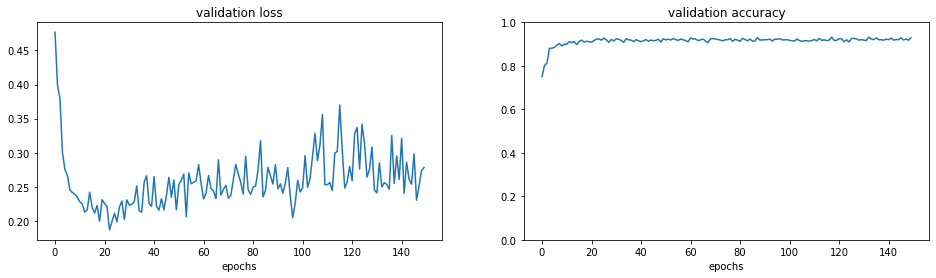

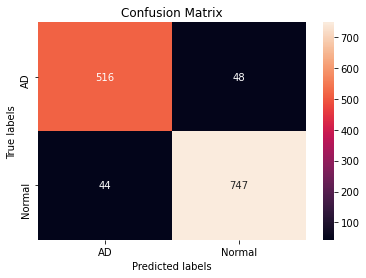

(1355, 2)
finished loading 13544 images from 2 categories
train / test split: 12189, 1355
training data shape:  (12189, 224, 224, 3)
training labels shape:  (12189, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                  

Epoch 13/150
380/381 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9206
Epoch 00013: val_accuracy improved from 0.90185 to 0.90996, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_3.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.1878 - accuracy: 0.9207 - val_loss: 0.2545 - val_accuracy: 0.9100
Epoch 14/150
380/381 [============================>.] - ETA: 0s - loss: 0.1752 - accuracy: 0.9292
Epoch 00014: val_accuracy did not improve from 0.90996
381/381 [==============================] - 5s 14ms/step - loss: 0.1752 - accuracy: 0.9291 - val_loss: 0.2587 - val_accuracy: 0.9018
Epoch 15/150
379/381 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9324
Epoch 00015: val_accuracy did not improve from 0.90996
381/381 [==============================] - 5s 14ms/step - loss: 0.1723 - accuracy: 0.9324 - val_loss: 0.2849 - 

Epoch 40/150
380/381 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9675
Epoch 00040: val_accuracy did not improve from 0.91661
381/381 [==============================] - 5s 14ms/step - loss: 0.0862 - accuracy: 0.9675 - val_loss: 0.2662 - val_accuracy: 0.9085
Epoch 41/150
379/381 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9678
Epoch 00041: val_accuracy did not improve from 0.91661
381/381 [==============================] - 5s 14ms/step - loss: 0.0853 - accuracy: 0.9680 - val_loss: 0.3018 - val_accuracy: 0.9144
Epoch 42/150
381/381 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9702
Epoch 00042: val_accuracy did not improve from 0.91661
381/381 [==============================] - 5s 14ms/step - loss: 0.0814 - accuracy: 0.9702 - val_loss: 0.2874 - val_accuracy: 0.9092
Epoch 43/150
378/381 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9702
Epoch 00043: val_accuracy did not improve from 

379/381 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9788
Epoch 00068: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0603 - accuracy: 0.9786 - val_loss: 0.3154 - val_accuracy: 0.9092
Epoch 69/150
379/381 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9767
Epoch 00069: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0677 - accuracy: 0.9769 - val_loss: 0.2936 - val_accuracy: 0.9092
Epoch 70/150
377/381 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9779
Epoch 00070: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0650 - accuracy: 0.9780 - val_loss: 0.3528 - val_accuracy: 0.9011
Epoch 71/150
377/381 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9766
Epoch 00071: val_accuracy did not improve from 0.91734
381/3

Epoch 97/150
378/381 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9789
Epoch 00097: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0614 - accuracy: 0.9789 - val_loss: 0.3977 - val_accuracy: 0.8819
Epoch 98/150
381/381 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9830
Epoch 00098: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0512 - accuracy: 0.9830 - val_loss: 0.3809 - val_accuracy: 0.9018
Epoch 99/150
380/381 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9817
Epoch 00099: val_accuracy did not improve from 0.91734
381/381 [==============================] - 5s 14ms/step - loss: 0.0529 - accuracy: 0.9816 - val_loss: 0.3355 - val_accuracy: 0.9092
Epoch 100/150
380/381 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9799
Epoch 00100: val_accuracy did not improve from

379/381 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9847
Epoch 00125: val_accuracy did not improve from 0.91808
381/381 [==============================] - 5s 14ms/step - loss: 0.0501 - accuracy: 0.9846 - val_loss: 0.3458 - val_accuracy: 0.9173
Epoch 126/150
379/381 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9866
Epoch 00126: val_accuracy did not improve from 0.91808
381/381 [==============================] - 5s 14ms/step - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.3109 - val_accuracy: 0.9144
Epoch 127/150
380/381 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9851
Epoch 00127: val_accuracy did not improve from 0.91808
381/381 [==============================] - 5s 14ms/step - loss: 0.0506 - accuracy: 0.9852 - val_loss: 0.3014 - val_accuracy: 0.9100
Epoch 128/150
377/381 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9823
Epoch 00128: val_accuracy did not improve from 0.91808
38

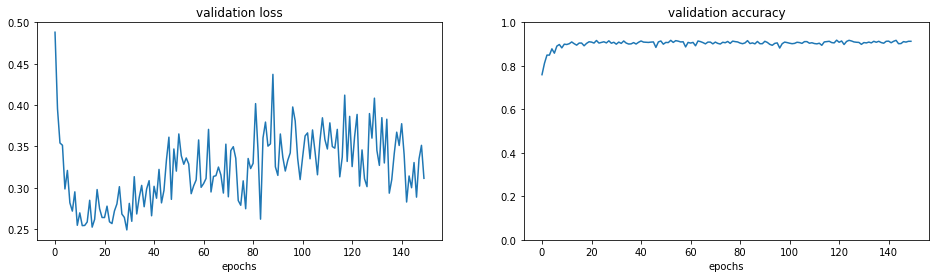

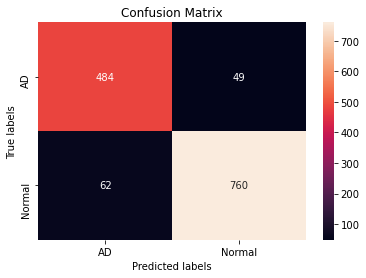

(1355, 2)
finished loading 13544 images from 2 categories
train / test split: 12189, 1355
training data shape:  (12189, 224, 224, 3)
training labels shape:  (12189, 2)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_18 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_19 (Activation)  (None, 109, 109, 32)      0         
                  

379/381 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9182
Epoch 00013: val_accuracy improved from 0.90554 to 0.91734, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_4.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.2044 - accuracy: 0.9181 - val_loss: 0.2227 - val_accuracy: 0.9173
Epoch 14/150
381/381 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9232
Epoch 00014: val_accuracy improved from 0.91734 to 0.91808, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_4.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.1897 - accuracy: 0.9232 - val_loss: 0.2137 - val_accuracy: 0.9181
Epoch 15/150
380/381 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9235
Epoch 00015: 

378/381 [============================>.] - ETA: 0s - loss: 0.0968 - accuracy: 0.9650
Epoch 00040: val_accuracy did not improve from 0.92915
381/381 [==============================] - 6s 15ms/step - loss: 0.0972 - accuracy: 0.9648 - val_loss: 0.2877 - val_accuracy: 0.8989
Epoch 41/150
378/381 [============================>.] - ETA: 0s - loss: 0.0862 - accuracy: 0.9696
Epoch 00041: val_accuracy did not improve from 0.92915
381/381 [==============================] - 5s 14ms/step - loss: 0.0866 - accuracy: 0.9695 - val_loss: 0.2535 - val_accuracy: 0.9092
Epoch 42/150
379/381 [============================>.] - ETA: 0s - loss: 0.0898 - accuracy: 0.9688
Epoch 00042: val_accuracy did not improve from 0.92915
381/381 [==============================] - 5s 14ms/step - loss: 0.0898 - accuracy: 0.9687 - val_loss: 0.2901 - val_accuracy: 0.9196
Epoch 43/150
378/381 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9659
Epoch 00043: val_accuracy did not improve from 0.92915
381/3

Epoch 69/150
381/381 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9776
Epoch 00069: val_accuracy did not improve from 0.92915
381/381 [==============================] - 5s 14ms/step - loss: 0.0621 - accuracy: 0.9776 - val_loss: 0.2616 - val_accuracy: 0.9292
Epoch 70/150
381/381 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9754
Epoch 00070: val_accuracy did not improve from 0.92915
381/381 [==============================] - 5s 14ms/step - loss: 0.0684 - accuracy: 0.9754 - val_loss: 0.2771 - val_accuracy: 0.9107
Epoch 71/150
378/381 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9782
Epoch 00071: val_accuracy did not improve from 0.92915
381/381 [==============================] - 5s 14ms/step - loss: 0.0614 - accuracy: 0.9783 - val_loss: 0.2851 - val_accuracy: 0.9210
Epoch 72/150
380/381 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9774
Epoch 00072: val_accuracy did not improve from 

Epoch 96/150
379/381 [============================>.] - ETA: 0s - loss: 0.0628 - accuracy: 0.9792
Epoch 00096: val_accuracy improved from 0.93284 to 0.93358, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_4.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.0631 - accuracy: 0.9792 - val_loss: 0.2779 - val_accuracy: 0.9336
Epoch 97/150
378/381 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9808
Epoch 00097: val_accuracy did not improve from 0.93358
381/381 [==============================] - 5s 14ms/step - loss: 0.0550 - accuracy: 0.9810 - val_loss: 0.2669 - val_accuracy: 0.9277
Epoch 98/150
378/381 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9828
Epoch 00098: val_accuracy did not improve from 0.93358
381/381 [==============================] - 5s 14ms/step - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.2710 - 

Epoch 123/150
381/381 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9854
Epoch 00123: val_accuracy did not improve from 0.94170
381/381 [==============================] - 5s 14ms/step - loss: 0.0424 - accuracy: 0.9854 - val_loss: 0.2580 - val_accuracy: 0.9343
Epoch 124/150
380/381 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9848
Epoch 00124: val_accuracy did not improve from 0.94170
381/381 [==============================] - 5s 14ms/step - loss: 0.0471 - accuracy: 0.9848 - val_loss: 0.3180 - val_accuracy: 0.9166
Epoch 125/150
378/381 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9842
Epoch 00125: val_accuracy did not improve from 0.94170
381/381 [==============================] - 5s 14ms/step - loss: 0.0435 - accuracy: 0.9842 - val_loss: 0.2773 - val_accuracy: 0.9328
Epoch 126/150
381/381 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9842
Epoch 00126: val_accuracy did not improve f

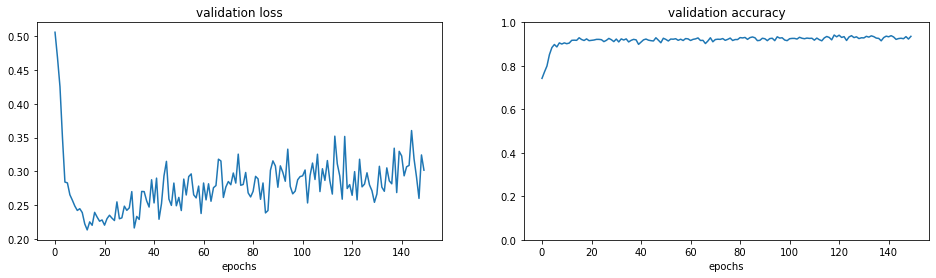

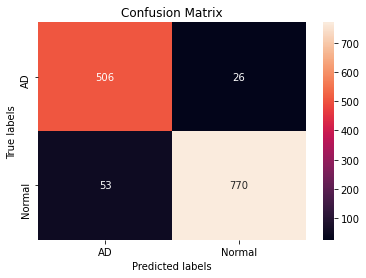

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_24 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_25 (Activation)  (None, 109, 109, 32)      0         
                  

379/381 [============================>.] - ETA: 0s - loss: 0.2168 - accuracy: 0.9116
Epoch 00013: val_accuracy did not improve from 0.91359
381/381 [==============================] - 5s 14ms/step - loss: 0.2168 - accuracy: 0.9114 - val_loss: 0.2154 - val_accuracy: 0.9032
Epoch 14/150
379/381 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9188
Epoch 00014: val_accuracy improved from 0.91359 to 0.91654, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_5.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.2032 - accuracy: 0.9188 - val_loss: 0.2178 - val_accuracy: 0.9165
Epoch 15/150
378/381 [============================>.] - ETA: 0s - loss: 0.1968 - accuracy: 0.9223
Epoch 00015: val_accuracy did not improve from 0.91654
381/381 [==============================] - 5s 14ms/step - loss: 0.1973 - accuracy: 0.9221 - val_loss: 0.1990 - val_accuracy:

381/381 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9649 ETA: 0s - loss: 0.0986 - accu
Epoch 00039: val_accuracy improved from 0.92984 to 0.93131, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_5.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.0974 - accuracy: 0.9649 - val_loss: 0.1969 - val_accuracy: 0.9313
Epoch 40/150
381/381 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9625
Epoch 00040: val_accuracy did not improve from 0.93131
381/381 [==============================] - 5s 14ms/step - loss: 0.0951 - accuracy: 0.9625 - val_loss: 0.2007 - val_accuracy: 0.9232
Epoch 41/150
378/381 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9664
Epoch 00041: val_accuracy did not improve from 0.93131
381/381 [==============================] - 5s 14ms/step - loss: 0.0871 - accuracy: 0.9664 - va

Epoch 66/150
381/381 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9764
Epoch 00066: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0666 - accuracy: 0.9764 - val_loss: 0.2128 - val_accuracy: 0.9239
Epoch 67/150
379/381 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9788
Epoch 00067: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0617 - accuracy: 0.9788 - val_loss: 0.2261 - val_accuracy: 0.9180
Epoch 68/150
378/381 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9781
Epoch 00068: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0603 - accuracy: 0.9781 - val_loss: 0.2115 - val_accuracy: 0.9261
Epoch 69/150
380/381 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9770
Epoch 00069: val_accuracy did not improve from 

Epoch 95/150
379/381 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9808
Epoch 00095: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 13ms/step - loss: 0.0527 - accuracy: 0.9808 - val_loss: 0.2325 - val_accuracy: 0.9321
Epoch 96/150
381/381 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9811
Epoch 00096: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0526 - accuracy: 0.9811 - val_loss: 0.2345 - val_accuracy: 0.9284
Epoch 97/150
381/381 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9829
Epoch 00097: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.2313 - val_accuracy: 0.9254
Epoch 98/150
380/381 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9821
Epoch 00098: val_accuracy did not improve from 

Epoch 124/150
381/381 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9825
Epoch 00124: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0501 - accuracy: 0.9825 - val_loss: 0.2350 - val_accuracy: 0.9269
Epoch 125/150
379/381 [============================>.] - ETA: 0s - loss: 0.0449 - accuracy: 0.9834
Epoch 00125: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0453 - accuracy: 0.9832 - val_loss: 0.2215 - val_accuracy: 0.9321
Epoch 126/150
378/381 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9820
Epoch 00126: val_accuracy did not improve from 0.93722
381/381 [==============================] - 5s 14ms/step - loss: 0.0560 - accuracy: 0.9819 - val_loss: 0.2779 - val_accuracy: 0.9254
Epoch 127/150
378/381 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9857
Epoch 00127: val_accuracy did not improve f

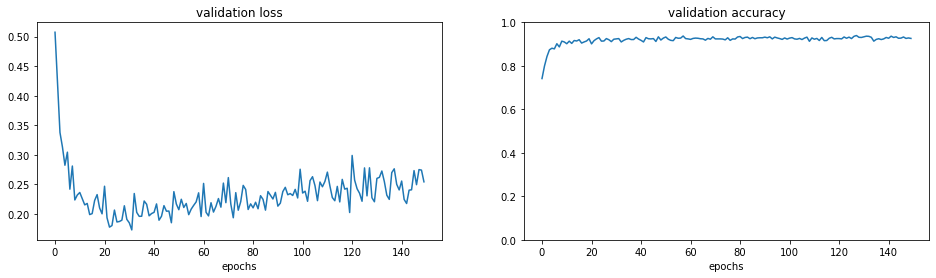

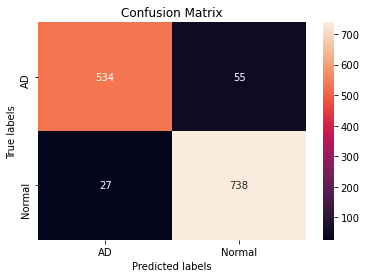

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_30 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_31 (Activation)  (None, 109, 109, 32)      0         
                  

Epoch 13/150
381/381 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9166
Epoch 00013: val_accuracy did not improve from 0.90842
381/381 [==============================] - 5s 13ms/step - loss: 0.2100 - accuracy: 0.9166 - val_loss: 0.2324 - val_accuracy: 0.9077
Epoch 14/150
377/381 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.9193
Epoch 00014: val_accuracy did not improve from 0.90842
381/381 [==============================] - 5s 13ms/step - loss: 0.1962 - accuracy: 0.9190 - val_loss: 0.2313 - val_accuracy: 0.9032
Epoch 15/150
378/381 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9239
Epoch 00015: val_accuracy improved from 0.90842 to 0.91137, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_6.best.hdf5
381/381 [==============================] - 5s 13ms/step - loss: 0.1908 - accuracy: 0.9241 - val_loss: 0.2217 - 

380/381 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9624
Epoch 00038: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0994 - accuracy: 0.9624 - val_loss: 0.2236 - val_accuracy: 0.9210
Epoch 39/150
381/381 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9652
Epoch 00039: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0964 - accuracy: 0.9652 - val_loss: 0.2402 - val_accuracy: 0.9225
Epoch 40/150
377/381 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9649
Epoch 00040: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0961 - accuracy: 0.9646 - val_loss: 0.2493 - val_accuracy: 0.9136
Epoch 41/150
377/381 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9654
Epoch 00041: val_accuracy did not improve from 0.92762
381/3

Epoch 67/150
377/381 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9765
Epoch 00067: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0659 - accuracy: 0.9766 - val_loss: 0.3395 - val_accuracy: 0.8936
Epoch 68/150
379/381 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9772
Epoch 00068: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0656 - accuracy: 0.9773 - val_loss: 0.2462 - val_accuracy: 0.9225
Epoch 69/150
378/381 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9760
Epoch 00069: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0640 - accuracy: 0.9760 - val_loss: 0.2946 - val_accuracy: 0.9158
Epoch 70/150
379/381 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9767
Epoch 00070: val_accuracy did not improve from 

Epoch 96/150
380/381 [============================>.] - ETA: 0s - loss: 0.0549 - accuracy: 0.9814
Epoch 00096: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0548 - accuracy: 0.9815 - val_loss: 0.2935 - val_accuracy: 0.9195
Epoch 97/150
378/381 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9845
Epoch 00097: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0477 - accuracy: 0.9845 - val_loss: 0.3206 - val_accuracy: 0.9202
Epoch 98/150
379/381 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9828
Epoch 00098: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0488 - accuracy: 0.9829 - val_loss: 0.2756 - val_accuracy: 0.9121
Epoch 99/150
378/381 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9840
Epoch 00099: val_accuracy did not improve from 

Epoch 125/150
378/381 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9841
Epoch 00125: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0464 - accuracy: 0.9842 - val_loss: 0.2609 - val_accuracy: 0.9239
Epoch 126/150
378/381 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9878
Epoch 00126: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.2581 - val_accuracy: 0.9195
Epoch 127/150
378/381 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9858
Epoch 00127: val_accuracy did not improve from 0.92762
381/381 [==============================] - 5s 13ms/step - loss: 0.0435 - accuracy: 0.9856 - val_loss: 0.3117 - val_accuracy: 0.9129
Epoch 128/150
381/381 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9836
Epoch 00128: val_accuracy did not improve f

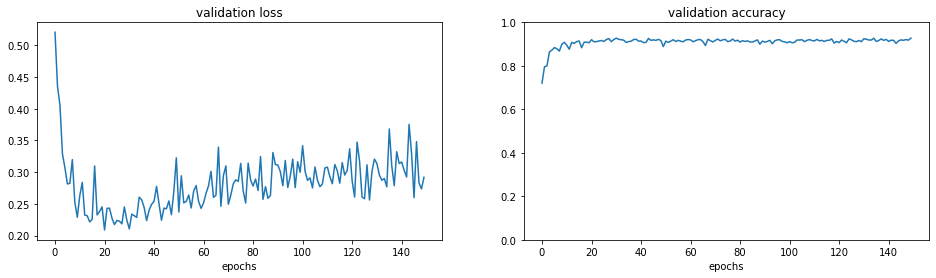

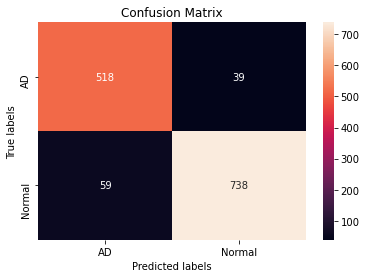

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_36 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_37 (Activation)  (None, 109, 109, 32)      0         
                  

Epoch 13/150
380/381 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9248
Epoch 00013: val_accuracy did not improve from 0.90473
381/381 [==============================] - 5s 14ms/step - loss: 0.1913 - accuracy: 0.9247 - val_loss: 0.2677 - val_accuracy: 0.8914
Epoch 14/150
379/381 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9305
Epoch 00014: val_accuracy did not improve from 0.90473
381/381 [==============================] - 5s 14ms/step - loss: 0.1755 - accuracy: 0.9306 - val_loss: 0.2731 - val_accuracy: 0.8914
Epoch 15/150
381/381 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9336
Epoch 00015: val_accuracy did not improve from 0.90473
381/381 [==============================] - 5s 14ms/step - loss: 0.1710 - accuracy: 0.9336 - val_loss: 0.2447 - val_accuracy: 0.8929
Epoch 16/150
378/381 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9329
Epoch 00016: val_accuracy did not improve from 

Epoch 40/150
380/381 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9717
Epoch 00040: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0840 - accuracy: 0.9717 - val_loss: 0.2883 - val_accuracy: 0.8959
Epoch 41/150
377/381 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9719
Epoch 00041: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0795 - accuracy: 0.9717 - val_loss: 0.2939 - val_accuracy: 0.8966
Epoch 42/150
378/381 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9716
Epoch 00042: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0727 - accuracy: 0.9715 - val_loss: 0.3023 - val_accuracy: 0.9032
Epoch 43/150
378/381 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9735
Epoch 00043: val_accuracy did not improve from 

Epoch 69/150
380/381 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9812
Epoch 00069: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0539 - accuracy: 0.9812 - val_loss: 0.3757 - val_accuracy: 0.8988
Epoch 70/150
380/381 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9812
Epoch 00070: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0596 - accuracy: 0.9813 - val_loss: 0.3117 - val_accuracy: 0.8944
Epoch 71/150
381/381 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9806
Epoch 00071: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0580 - accuracy: 0.9806 - val_loss: 0.3360 - val_accuracy: 0.8951
Epoch 72/150
380/381 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9787
Epoch 00072: val_accuracy did not improve from 

Epoch 98/150
378/381 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9862
Epoch 00098: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0370 - accuracy: 0.9861 - val_loss: 0.3880 - val_accuracy: 0.8907
Epoch 99/150
377/381 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9837
Epoch 00099: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0438 - accuracy: 0.9837 - val_loss: 0.3491 - val_accuracy: 0.9018
Epoch 100/150
381/381 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9820
Epoch 00100: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0536 - accuracy: 0.9820 - val_loss: 0.3612 - val_accuracy: 0.8973
Epoch 101/150
379/381 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9819
Epoch 00101: val_accuracy did not improve fro

Epoch 127/150
378/381 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9867
Epoch 00127: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0417 - accuracy: 0.9866 - val_loss: 0.3234 - val_accuracy: 0.8951
Epoch 128/150
381/381 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9893
Epoch 00128: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.3812 - val_accuracy: 0.9032
Epoch 129/150
381/381 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9857
Epoch 00129: val_accuracy did not improve from 0.91137
381/381 [==============================] - 5s 14ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.3293 - val_accuracy: 0.9025
Epoch 130/150
381/381 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9844
Epoch 00130: val_accuracy did not improve f

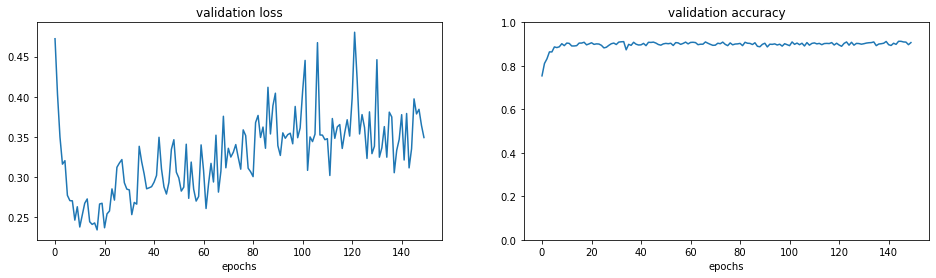

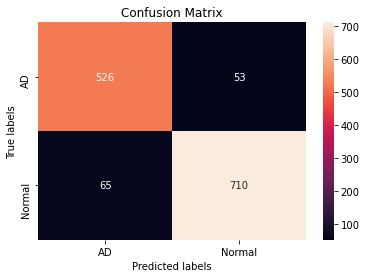

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_43 (Activation)  (None, 109, 109, 32)      0         
                  

Epoch 12/150
377/381 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9179
Epoch 00012: val_accuracy did not improve from 0.91285
381/381 [==============================] - 5s 13ms/step - loss: 0.2010 - accuracy: 0.9173 - val_loss: 0.2444 - val_accuracy: 0.9099
Epoch 13/150
381/381 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9233
Epoch 00013: val_accuracy did not improve from 0.91285
381/381 [==============================] - 5s 13ms/step - loss: 0.1890 - accuracy: 0.9233 - val_loss: 0.2565 - val_accuracy: 0.9025
Epoch 14/150
378/381 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9240
Epoch 00014: val_accuracy improved from 0.91285 to 0.91876, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_8.best.hdf5
381/381 [==============================] - 5s 13ms/step - loss: 0.1813 - accuracy: 0.9242 - val_loss: 0.2445 - 

Epoch 39/150
380/381 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9694
Epoch 00039: val_accuracy did not improve from 0.92984
381/381 [==============================] - 5s 13ms/step - loss: 0.0830 - accuracy: 0.9695 - val_loss: 0.2912 - val_accuracy: 0.9291
Epoch 40/150
378/381 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9705
Epoch 00040: val_accuracy did not improve from 0.92984
381/381 [==============================] - 5s 13ms/step - loss: 0.0818 - accuracy: 0.9707 - val_loss: 0.2625 - val_accuracy: 0.9239
Epoch 41/150
380/381 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9739
Epoch 00041: val_accuracy did not improve from 0.92984
381/381 [==============================] - 5s 13ms/step - loss: 0.0717 - accuracy: 0.9740 - val_loss: 0.3110 - val_accuracy: 0.9298
Epoch 42/150
379/381 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9717
Epoch 00042: val_accuracy improved from 0.92984

Epoch 66/150
380/381 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9808
Epoch 00066: val_accuracy did not improve from 0.93575
381/381 [==============================] - 5s 13ms/step - loss: 0.0521 - accuracy: 0.9807 - val_loss: 0.3126 - val_accuracy: 0.9291
Epoch 67/150
377/381 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9802
Epoch 00067: val_accuracy did not improve from 0.93575
381/381 [==============================] - 5s 13ms/step - loss: 0.0578 - accuracy: 0.9803 - val_loss: 0.3044 - val_accuracy: 0.9313
Epoch 68/150
380/381 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9794
Epoch 00068: val_accuracy did not improve from 0.93575
381/381 [==============================] - 5s 13ms/step - loss: 0.0611 - accuracy: 0.9795 - val_loss: 0.2753 - val_accuracy: 0.9321
Epoch 69/150
381/381 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9811
Epoch 00069: val_accuracy did not improve from 

381/381 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9829
Epoch 00094: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0477 - accuracy: 0.9829 - val_loss: 0.3148 - val_accuracy: 0.9313
Epoch 95/150
377/381 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9855
Epoch 00095: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0431 - accuracy: 0.9854 - val_loss: 0.3422 - val_accuracy: 0.9291
Epoch 96/150
381/381 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9833
Epoch 00096: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0476 - accuracy: 0.9833 - val_loss: 0.2639 - val_accuracy: 0.9202
Epoch 97/150
377/381 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9840
Epoch 00097: val_accuracy did not improve from 0.94165
381/3

Epoch 123/150
379/381 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9845
Epoch 00123: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0441 - accuracy: 0.9846 - val_loss: 0.3493 - val_accuracy: 0.9350
Epoch 124/150
380/381 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9866
Epoch 00124: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.3501 - val_accuracy: 0.9291
Epoch 125/150
381/381 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9891
Epoch 00125: val_accuracy did not improve from 0.94165
381/381 [==============================] - 5s 13ms/step - loss: 0.0329 - accuracy: 0.9891 - val_loss: 0.3477 - val_accuracy: 0.9291
Epoch 126/150
379/381 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9860
Epoch 00126: val_accuracy did not improve f

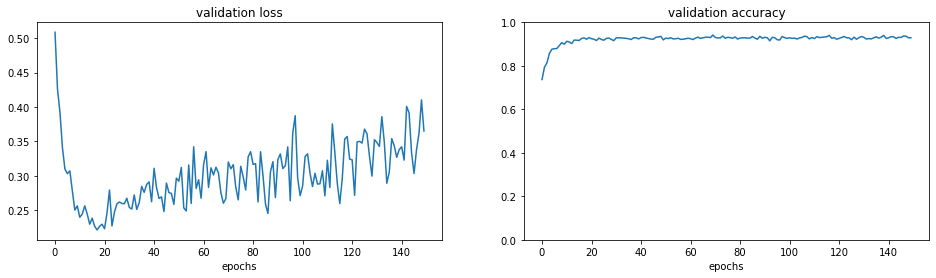

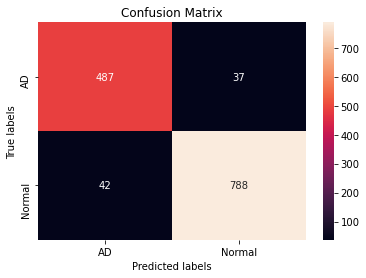

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_48 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_49 (Activation)  (None, 109, 109, 32)      0         
                  

Epoch 13/150
377/381 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9275
Epoch 00013: val_accuracy improved from 0.91064 to 0.91433, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_9.best.hdf5
381/381 [==============================] - 5s 13ms/step - loss: 0.1862 - accuracy: 0.9274 - val_loss: 0.2162 - val_accuracy: 0.9143
Epoch 14/150
380/381 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9283
Epoch 00014: val_accuracy did not improve from 0.91433
381/381 [==============================] - 5s 13ms/step - loss: 0.1829 - accuracy: 0.9284 - val_loss: 0.2204 - val_accuracy: 0.9106
Epoch 15/150
377/381 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9318
Epoch 00015: val_accuracy improved from 0.91433 to 0.91728, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification

Epoch 40/150
378/381 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9707
Epoch 00040: val_accuracy did not improve from 0.93205
381/381 [==============================] - 5s 13ms/step - loss: 0.0824 - accuracy: 0.9706 - val_loss: 0.2350 - val_accuracy: 0.9261
Epoch 41/150
377/381 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9775
Epoch 00041: val_accuracy did not improve from 0.93205
381/381 [==============================] - 5s 13ms/step - loss: 0.0665 - accuracy: 0.9776 - val_loss: 0.2387 - val_accuracy: 0.9247
Epoch 42/150
379/381 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9781
Epoch 00042: val_accuracy did not improve from 0.93205
381/381 [==============================] - 5s 13ms/step - loss: 0.0615 - accuracy: 0.9780 - val_loss: 0.2674 - val_accuracy: 0.9269
Epoch 43/150
380/381 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9744
Epoch 00043: val_accuracy did not improve from 

377/381 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9840
Epoch 00068: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0465 - accuracy: 0.9842 - val_loss: 0.2598 - val_accuracy: 0.9261
Epoch 69/150
378/381 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9821
Epoch 00069: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0510 - accuracy: 0.9822 - val_loss: 0.3003 - val_accuracy: 0.9276
Epoch 70/150
377/381 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9866
Epoch 00070: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0421 - accuracy: 0.9865 - val_loss: 0.2532 - val_accuracy: 0.9247
Epoch 71/150
377/381 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9856
Epoch 00071: val_accuracy did not improve from 0.93648
381/3

Epoch 97/150
378/381 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9851
Epoch 00097: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0465 - accuracy: 0.9851 - val_loss: 0.2994 - val_accuracy: 0.9165
Epoch 98/150
379/381 [============================>.] - ETA: 0s - loss: 0.0359 - accuracy: 0.9878
Epoch 00098: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0357 - accuracy: 0.9879 - val_loss: 0.3455 - val_accuracy: 0.9188
Epoch 99/150
378/381 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9857
Epoch 00099: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0424 - accuracy: 0.9857 - val_loss: 0.2616 - val_accuracy: 0.9254
Epoch 100/150
378/381 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9870
Epoch 00100: val_accuracy did not improve from

Epoch 126/150
378/381 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.9902
Epoch 00126: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0287 - accuracy: 0.9902 - val_loss: 0.2808 - val_accuracy: 0.9247
Epoch 127/150
378/381 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9885
Epoch 00127: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0352 - accuracy: 0.9884 - val_loss: 0.2778 - val_accuracy: 0.9151
Epoch 128/150
379/381 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9910
Epoch 00128: val_accuracy did not improve from 0.93648
381/381 [==============================] - 5s 13ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.2984 - val_accuracy: 0.9173
Epoch 129/150
380/381 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9877
Epoch 00129: val_accuracy did not improve f

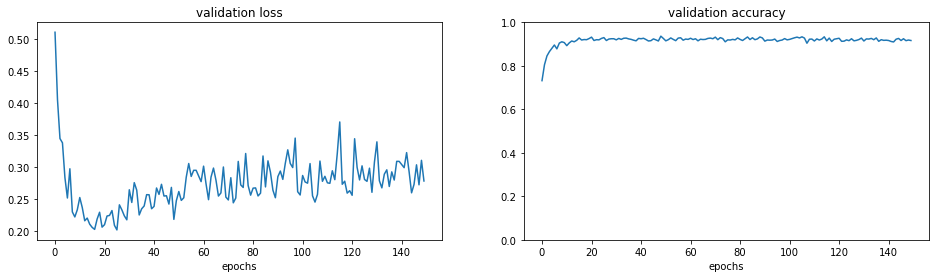

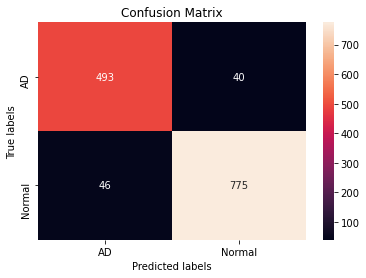

(1354, 2)
finished loading 13544 images from 2 categories
train / test split: 12190, 1354
training data shape:  (12190, 224, 224, 3)
training labels shape:  (12190, 2)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_54 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 activation_55 (Activation)  (None, 109, 109, 32)      0         
                  

381/381 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9251
Epoch 00013: val_accuracy did not improve from 0.90842
381/381 [==============================] - 5s 14ms/step - loss: 0.1882 - accuracy: 0.9251 - val_loss: 0.2707 - val_accuracy: 0.8959
Epoch 14/150
379/381 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9307
Epoch 00014: val_accuracy did not improve from 0.90842
381/381 [==============================] - 5s 14ms/step - loss: 0.1765 - accuracy: 0.9305 - val_loss: 0.2422 - val_accuracy: 0.9062
Epoch 15/150
378/381 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9361
Epoch 00015: val_accuracy improved from 0.90842 to 0.91876, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_10.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.1680 - accuracy: 0.9358 - val_loss: 0.2246 - val_accuracy

Epoch 40/150
381/381 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9739
Epoch 00040: val_accuracy did not improve from 0.92541
381/381 [==============================] - 5s 14ms/step - loss: 0.0689 - accuracy: 0.9739 - val_loss: 0.3329 - val_accuracy: 0.9062
Epoch 41/150
380/381 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9728
Epoch 00041: val_accuracy did not improve from 0.92541
381/381 [==============================] - 5s 14ms/step - loss: 0.0762 - accuracy: 0.9728 - val_loss: 0.2826 - val_accuracy: 0.9210
Epoch 42/150
379/381 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9759
Epoch 00042: val_accuracy did not improve from 0.92541
381/381 [==============================] - 5s 14ms/step - loss: 0.0697 - accuracy: 0.9759 - val_loss: 0.3152 - val_accuracy: 0.9121
Epoch 43/150
380/381 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9735
Epoch 00043: val_accuracy did not improve from 

381/381 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9828
Epoch 00068: val_accuracy did not improve from 0.92614
381/381 [==============================] - 5s 14ms/step - loss: 0.0546 - accuracy: 0.9828 - val_loss: 0.3076 - val_accuracy: 0.9232
Epoch 69/150
379/381 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9810
Epoch 00069: val_accuracy did not improve from 0.92614
381/381 [==============================] - 5s 14ms/step - loss: 0.0522 - accuracy: 0.9811 - val_loss: 0.2955 - val_accuracy: 0.9173
Epoch 70/150
380/381 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9856
Epoch 00070: val_accuracy improved from 0.92614 to 0.93279, saving model to C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32\CNN_model_fold_10.best.hdf5
381/381 [==============================] - 5s 14ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.3414 - val_accuracy

380/381 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9865
Epoch 00096: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.2940 - val_accuracy: 0.9254
Epoch 97/150
381/381 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9864
Epoch 00097: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0398 - accuracy: 0.9864 - val_loss: 0.3758 - val_accuracy: 0.9202
Epoch 98/150
381/381 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9862
Epoch 00098: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.3154 - val_accuracy: 0.9217
Epoch 99/150
381/381 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9868
Epoch 00099: val_accuracy did not improve from 0.93279
381/3

Epoch 125/150
377/381 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9874
Epoch 00125: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0385 - accuracy: 0.9873 - val_loss: 0.3301 - val_accuracy: 0.9306
Epoch 126/150
381/381 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9899
Epoch 00126: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.3358 - val_accuracy: 0.9269
Epoch 127/150
381/381 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9863
Epoch 00127: val_accuracy did not improve from 0.93279
381/381 [==============================] - 5s 14ms/step - loss: 0.0474 - accuracy: 0.9863 - val_loss: 0.3250 - val_accuracy: 0.9247
Epoch 128/150
381/381 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9879
Epoch 00128: val_accuracy did not improve f

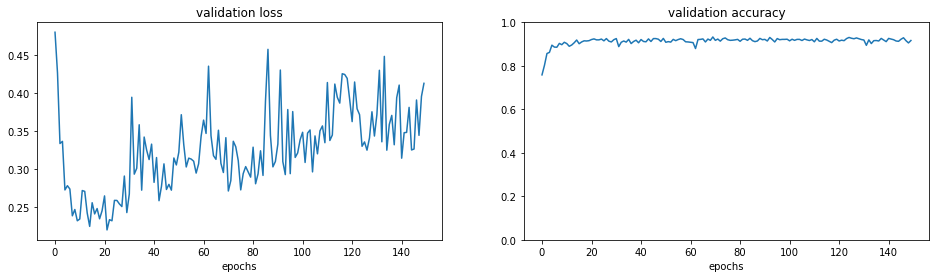

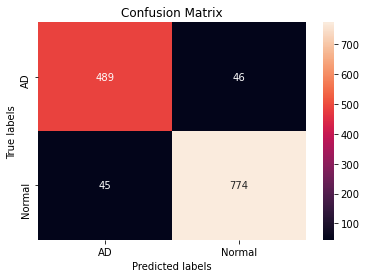

In [8]:
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

import tensorflow as tf
import pandas as pd
from tensorflow.keras import utils as np_utils

tf.keras.backend.clear_session()

# K-fold Cross Validation model evaluation
fold_no = 1
for fold_no in range(1, 11):
    
    train=pd.read_csv(f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/train{fold_no}.csv", sep=',',header=None)
    test=pd.read_csv(f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/test{fold_no}.csv", sep=',',header=None)
    
    x_train = X[train[0]]
    y_train = y[train[0]]
    x_test = X[test[0]]
    y_test = y[test[0]]

    # x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
    # x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

    # normalize data
    # x_train = x_train.astype('float32') / 255.
    # x_test = x_test.astype('float32') / 255.

    # convert labels to one-hot vectors
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    print(y_test.shape)

    # summary
    print("finished loading %d images from %d categories"%(len(data), num_classes))
    print("train / test split: %d, %d"%(len(x_train), len(x_test)))
    print("training data shape: ", x_train.shape)
    print("training labels shape: ", y_train.shape)

    #x_train = X[train]
    #y_train = y[train]
    #x_test = X[test]
    #y_test = y[test]
    
    
    # build the network
    model = Sequential()
    #print("Input dimensions: ",x_train.shape[1:])

    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #filepath="C:/Users/s4629860/Documents/Workspace/SZ/Dataset 5/CNN_epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
    filepath=f"C:/Users/s4629860/Documents/workspace/Mam Project/method 3/Data/derivatives/classification/spectogram/FTDvsHC/Full/32/CNN_model_fold_{fold_no}.best.hdf5"
    
    # define early stopping callback
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=150, mode='auto')

    # saves the model weights after each epoch if the validation loss decreased
    #checkpointer = ModelCheckpoint(filepath='LSTM_model.best.hdf5', verbose=1, save_best_only=True)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_accuracy')

    callbacks_list = [earlystop, checkpointer]
    
    history = model.fit(x_train, y_train, epochs = 150, batch_size=32,validation_data= (x_test, y_test), callbacks = callbacks_list)

    #load saved best model
    model = load_model(filepath)

    # Generate generalization metrics
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    Y_pred = model.predict(x_test)
    y_pred = np.argmax(Y_pred, axis=1)
    y_text_new = np.argmax(y_test, axis=1)

    from sklearn.metrics import classification_report, confusion_matrix
    #Confution Matrix and Classification Report

    print('Confusion Matrix')
    confusion = confusion_matrix(y_text_new, y_pred)
    print(confusion)
    print('Classification Report')
    target_names = ['AD', 'Normal']
    print(classification_report(y_text_new, y_pred, target_names=target_names))

    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"])
    ax.set_title("validation loss")
    ax.set_xlabel("epochs")

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_accuracy"])
    ax2.set_title("validation accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)

    # Increase fold number
    #fold_no = fold_no + 1
    plt.show()
    
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, fmt="d", ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['AD', 'Normal']); ax.yaxis.set_ticklabels(['AD', 'Normal']);
    plt.show()    

In [9]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.262430876493454 - Accuracy: 92.98893213272095%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.24807381629943848 - Accuracy: 93.21033358573914%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.38637620210647583 - Accuracy: 91.80811643600464%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.27481579780578613 - Accuracy: 94.16974186897278%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2780655324459076 - Accuracy: 93.94387006759644%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.2106626182794571 - Accuracy: 92.7621841430664%
-----------------------------------------------------------------------